# TIG Welding Defect Classification Using Quantum Neural Networks

This notebook demonstrates the use of a Quantum Convolutional Neural Network (QCNN) to classify defects in TIG welding. The model processes images from the TIG Aluminum dataset to identify good and bad welds.

In [1]:
import pennylane as qml
import pennylane.numpy as pnp
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import json
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, Subset
from torchvision import transforms

C:\Users\f_elg\anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\f_elg\anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\f_elg\anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Data Preprocessing Function

The `preprocess_dataset` function is designed to prepare the image data for input into a quantum neural network. This process involves several key steps to ensure the data is in the correct format and scale for processing by the quantum circuit.

#### Steps Involved:

1. **Flattening the Images**:
   - Each image is reshaped into a one-dimensional array. This flattening process is essential for feeding the data into the quantum circuit, which expects a linear input format.

2. **Normalization**:
   - The pixel values of the images are normalized to a range between 0 and \(\pi\) using the `MinMaxScaler`. This scaling is crucial as it aligns the data with the input requirements of quantum operations, which often involve angles in radians.

3. **Dimensionality Reduction**:
   - The dimensionality of the data is reduced to match the number of qubits (`n_qubits`) used in the quantum model. This step ensures that the input size is compatible with the quantum circuit's architecture, which can process a limited number of features due to its qubit constraints.

This preprocessing pipeline ensures that the image data is appropriately formatted and scaled, allowing the quantum neural network to effectively learn and classify TIG welding defects.

In [2]:
def preprocess_dataset(x_train, x_test, y_train, y_test):
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    
    # Flatten the images
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, pnp.pi))
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Reduce dimensionality to match our circuit size
    x_train = x_train[:, :n_qubits]
    x_test = x_test[:, :n_qubits]
    
    return x_train, y_train, x_test, y_test

### Custom Dataset Class: MyDataset

The `MyDataset` class is a custom implementation for loading and handling image data from the TIG Aluminum dataset. It extends PyTorch's `Dataset` class, allowing seamless integration with PyTorch's data loading utilities.

#### Initialization

- **Parameters**:
  - `path`: The root directory path where the dataset is stored.
  - `transform`: Optional transformations to apply to the images (e.g., resizing, normalization).
  - `train`: A boolean indicating whether to load the training or testing dataset.
  - `class2`: A boolean to enable binary classification by converting labels greater than 1 to 1.

- **Loading Data**:
  - The dataset information is loaded from a JSON file located in the specified directory. This file contains mappings of image paths to their corresponding labels.
  - The data is stored as a list of tuples, each containing an image path and its label.

#### Methods

- **`__len__`**:
  - Returns the total number of samples in the dataset, allowing PyTorch to iterate over the dataset.

- **`__getitem__`**:
  - Retrieves an image and its label at the specified index.
  - The image is loaded from the disk using the provided path and opened with the `PIL` library.
  - If a transformation is specified, it is applied to the image.
  - For binary classification (`class2=True`), labels greater than 1 are set to 1, simplifying the task to distinguishing between two classes.

This custom dataset class facilitates efficient data loading and preprocessing, making it easier to handle the TIG Aluminum images and labels for training and evaluation in a neural network model.


In [3]:
class MyDataset(Dataset):
    
    def __init__(self, path: str, transform=None, train: bool=True, class2: bool=True):
        self.transform = transform
        self.path = path
        self.mode = 'train' if train else 'test'
        self.class2 = class2
        
        with open (f"{path}/{self.mode}/{self.mode}.json", "r") as f:
            self.dataset_info = json.load(f)
        
        self.data = [(k, v) for k, v in self.dataset_info.items()]
    
    def __len__(self):
        return len(self.dataset_info)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(f"{self.path}/{self.mode}/{image_path}")
        if self.transform:
            image = self.transform(image)
            
        if self.class2 and label > 1:
            label = 1
        
        return image, label

### Dataset Preparation for TIG Welding Defect Classification

In this section, we prepare the TIG Aluminum dataset for training and testing the Quantum Convolutional Neural Network (QCNN):

#### Dataset Creation

- **Training Dataset**: 
  - We instantiate the `MyDataset` class for the training data, specifying the path to the dataset and applying a series of transformations.
  - **Transformations**: Images are resized to a dimension of 800x947 pixels and converted to tensors using `transforms.Compose`. This ensures consistency in input size and format for the model.
  - **Binary Classification**: The `class2=True` parameter enables binary classification, where labels greater than 1 are converted to 1.

- **Testing Dataset**:
  - Similarly, the `MyDataset` class is instantiated for the testing data with the same transformations and binary classification setup.

In [4]:
size = (800, 947)
path = "./al5083"

train_dataset_2class = MyDataset(
    path=path,
    transform=transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ]),
    train=True,
    class2=True
)
test_dataset_2class = MyDataset(
    path=path,
    transform=transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ]),
    train=False,
    class2=True
)

print("The length of the training datset:", len(train_dataset_2class))
print("The length of the testing datset:", len(test_dataset_2class))

The length of the training datset: 26666
The length of the testing datset: 6588


### Subset Selection and Data Preparation

In this section, we create subsets of the training and testing datasets from the TIG Aluminum dataset to manage computational resources effectively and prepare the data for input into the model.

#### Subset Creation

- **Training Subset**:
  - A subset of 1000 samples is randomly selected from the full training dataset using `torch.randperm`. This random permutation ensures a diverse and representative sample for training.
  - The `Subset` class from PyTorch is used to create this subset, which is then used for training the model.

- **Testing Subset**:
  - Similarly, a subset of 500 samples is selected from the testing dataset. This subset will be used to evaluate the model's performance.

In [5]:
subset_size = 1000
subset_indices = torch.randperm(len(train_dataset_2class))[:subset_size]
subset_train = Subset(train_dataset_2class, subset_indices)

test_subset_size = 500
test_subset_indices = torch.randperm(len(test_dataset_2class))[:test_subset_size]
subset_test = Subset(test_dataset_2class, test_subset_indices)

#### Data Zipping

The features (images) and labels from the training and testing subsets are zipped together using the `zip` function. This process organizes the data into tuples of `(image, label)`, making it easier to iterate over the dataset during training and evaluation.

These steps ensure that a manageable and representative portion of the TIG Aluminum dataset is used for model training and testing, facilitating efficient computation and evaluation.

In [6]:
# Zipping the features and labels together for each of the training and testing sets.
train_images, train_labels = tuple(zip(*subset_train))
test_images, test_labels = tuple(zip(*subset_test))

## Quantum model

### Quantum Model for TIG Welding Defect Classification

This section outlines the design and implementation of a Quantum Convolutional Neural Network (QCNN) for classifying defects in TIG welding. The model leverages quantum circuits to process image data and identify good and bad welds.

#### Quantum Circuit Design

- **Number of Qubits and Layers**:
  - The model uses 4 qubits, and the number of layers is determined by the logarithm base 2 of the number of qubits, resulting in 2 layers.

- **Device Setup**:
  - A quantum device is initialized using PennyLane's `default.qubit` simulator with 4 wires.

- **Circular Nearest Neighbor**:
  - This function defines the connectivity pattern for the qubits, ensuring each qubit is connected to its nearest neighbor in a circular fashion. This pattern is used to create entanglement in the quantum circuit.

#### Quantum Layers

- **Quantum Convolutional Layer**:
  - Applies parameterized rotations (RY gates) and CNOT gates to entangle qubits, capturing complex patterns in the data.

- **Quantum Pooling Layer**:
  - Utilizes controlled rotations (CRZ and CRX gates) and Pauli-X gates to reduce dimensionality while maintaining essential features.

#### QCNN Circuit

- **Angle Embedding**:
  - Input data is embedded into the quantum circuit using angle embedding, which maps classical data to quantum states.

- **Layer Iteration**:
  - The circuit iterates through the defined layers, applying convolutional and pooling operations to the active qubits (the qubits being divided by two each iteration). 

- **Output**:
  - The circuit returns the expectation value of the Pauli-Z operator on the first qubit, which is used to make predictions.

This quantum model is integrated with classical preprocessing and optimization techniques to classify TIG welding defects effectively. The combination of quantum and classical methods aims to enhance the model's performance and provide insights into the potential of quantum computing in industrial applications.

In [7]:
n_qubits = 4
n_layers = int(pnp.log2(n_qubits)) 

dev = qml.device("default.qubit", wires=n_qubits)

def circular_nearest_neighbor(wires):
    edges = []
    seen = set()
    for i in range(len(wires)):
        a, b = i, (i + 1) % len(wires)
        if (b, a) not in seen:
            edges.append((a, b))
            seen.add((a, b))
    return edges

def quantum_conv_layer(params, wires):
    for wire1, wire2 in circular_nearest_neighbor(wires):
        qml.RY(params[0], wires=wire1)
        qml.RY(params[1], wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

def quantum_pool_layer(params, wires):
    for wire1, wire2 in circular_nearest_neighbor(wires):
        qml.CRZ(params[0], wires=[wire1, wire2])
        qml.PauliX(wires=wire1)
        qml.CRX(params[1], wires=[wire1, wire2])
        qml.PauliX(wires=wire1)

@qml.qnode(dev)
def qcnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    
    weight_idx = 0
    for layer in reversed(range(n_layers)):
        n_active = 2 ** (layer + 1)
        active_wires = list(range(n_qubits - n_active, n_qubits))
        
        quantum_conv_layer(weights[weight_idx:weight_idx+n_active], wires=active_wires)
        weight_idx += n_active
        qml.Barrier(wires=range(n_qubits))
        
        quantum_pool_layer(weights[weight_idx:weight_idx+n_active], wires=active_wires)
        weight_idx += n_active
        qml.Barrier(wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

### Quantum Circuit Visualization

In this section, we visualize the structure of the Quantum Convolutional Neural Network (QCNN) circuit using dummy inputs and weights. This visualization helps to understand the flow and operations within the quantum circuit.

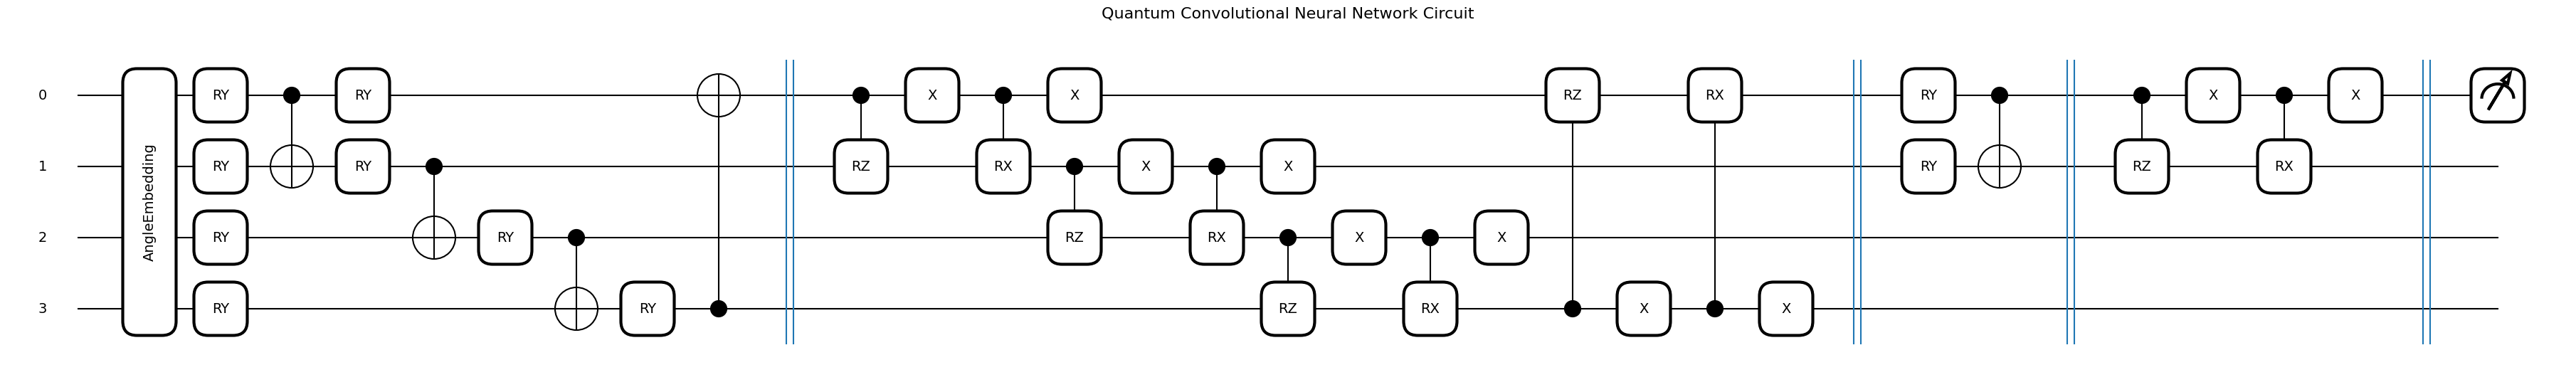

In [8]:
# Create dummy inputs and weights for drawing
dummy_inputs = pnp.zeros(n_qubits)
total_params = 4 * n_qubits - 4
dummy_weights = pnp.zeros(total_params)

fig, ax = qml.draw_mpl(qcnn_circuit)(dummy_inputs, dummy_weights)
plt.title("Quantum Convolutional Neural Network Circuit", fontsize=16)
plt.show()

### Quantum Network and Cost Calculation

This section defines the functions used to evaluate the performance of the Quantum Convolutional Neural Network (QCNN) for classifying TIG welding defects.

#### Quantum Network Function

This function computes the output of the QCNN circuit and normalizes it to the range [0, 1]. The normalization is achieved by adjusting the circuit's output, originally in the range [-1, 1], to match the probability interpretation required for classification tasks.

#### Cross-Entropy Loss

This function calculates the cross-entropy loss, a common metric for evaluating classification models. Predictions are clipped to avoid log(0) issues, ensuring stable computation. The loss is computed as:
    $$
    \text{Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right)
    $$
  - Here, $ y_i $ is the true label and $ \hat{y}_i $ is the predicted probability.

#### Cost Function

This function calculates the average cross-entropy loss over a batch of inputs. The function first generates predictions using the `quantum_net` function for each input sample. The cost function serves as the objective to be minimized during training, guiding the optimization of the QCNN's parameters to improve classification accuracy.

These functions form the core of the model's evaluation and optimization process, ensuring that the QCNN is effectively trained to classify defects in TIG welding.

In [9]:
def quantum_net(inputs, weights):
    return (qcnn_circuit(inputs, weights) + 1) / 2

def cross_entropy(predictions, labels):
    epsilon = 1e-15
    predictions = pnp.clip(predictions, epsilon, 1 - epsilon)
    return -pnp.mean(labels * pnp.log(predictions) + (1 - labels) * pnp.log(1 - predictions))

def cost(weights, inputs, labels):
    predictions = pnp.array([quantum_net(x, weights) for x in inputs])
    return cross_entropy(predictions, labels)

### Parameter Initialization and Data Preprocessing

#### Parameter Initialization

The number of parameters required for the QCNN is calculated as $4 \times \text{n\_qubits} - 4$. These parameters correspond to the trainable weights in the quantum circuit. The weights are initialized randomly within the range $[0, 2\pi]$, allowing the model to start with diverse initial conditions for optimization.


In [10]:
total_params = 4 * n_qubits - 4  # Total number of parameters needed
weights = pnp.random.uniform(0, 2*pnp.pi, total_params, requires_grad=True)

#### Data Preprocessing

The training and validation images are converted from tensors to NumPy arrays for compatibility with the preprocessing function. The `preprocess_dataset` function is applied to the training and validation datasets to flatten, normalize, and reduce the dimensionality of the images to match the quantum circuit's input requirements.

In [11]:
# Preprocessing the data
x_train, x_val = [x.detach().numpy()[0] for x in train_images], [x.detach().numpy()[0] for x in test_images]
y_train, y_val = np.array(train_labels), np.array(test_labels)
x_train, y_train, x_val, y_val = preprocess_dataset(x_train, x_val, y_train, y_val)

#### Class Distribution Analysis

The percentage of good and bad welds in the training set is calculated to understand the class distribution:
  - **Good Welds**: Calculated as the proportion of samples labeled as '0'.
  - **Bad Welds**: Calculated as the proportion of samples labeled as '1'.

In [12]:
goodweld_train_perc = len(y_train[y_train == 0]) / len(y_train) * 100
badweld_train_perc = len(y_train[y_train == 1]) / len(y_train) * 100
print("Percentage of good weld in the training set:", goodweld_train_perc, "%")
print("Percentage of bad weld in the training set:", badweld_train_perc, "%")

Percentage of good weld in the training set: 32.5 %
Percentage of bad weld in the training set: 67.5 %


### Training the Quantum Convolutional Neural Network

This section describes the training process for the Quantum Convolutional Neural Network (QCNN) using the Adam optimizer. The model is trained to classify defects in TIG welding based on the preprocessed dataset.

#### Optimization Setup

- **Optimizer**: The Adam optimizer is utilized with a learning rate (stepsize) of 0.001. This optimizer is chosen for its efficiency in handling sparse gradients and adaptive learning rates.
- **Batch Size and Steps**: Training is conducted in mini-batches of size 32 over a total of 10,000 steps. This approach helps in efficient convergence and reduces memory usage.

#### Training Loop

- **Batch Sampling**: In each iteration, a random batch of training data is selected, and the model weights are updated using the optimizer.
- **Cost Evaluation**: Every 10 steps, the training and validation costs are calculated and recorded. These metrics provide insights into the model's performance and convergence behavior.

#### Early Stopping

- **Validation Monitoring**: The validation cost is tracked to identify the best-performing model. If the validation cost does not improve for 10 consecutive evaluations (patience), training is halted early to prevent overfitting.
- **Best Weights**: The weights corresponding to the lowest validation cost are saved as the best model parameters.

In [13]:
opt = qml.AdamOptimizer(stepsize=0.001)
batch_size = 32
steps = 10000

best_val_cost = float('inf')
patience = 10 #20
no_improvement = 0

train_costs = []
val_costs = []

for i in range(steps):
    batch_indices = pnp.random.choice(len(x_train), batch_size, replace=False)
    x_batch = x_train[batch_indices]
    y_batch = y_train[batch_indices]
    
    weights = opt.step(lambda w: cost(w, x_batch, y_batch), weights)
    
    if (i + 1) % 10 == 0:
        train_cost = cost(weights, x_train, y_train)
        val_cost = cost(weights, x_val, y_val)
        train_costs.append(train_cost)
        val_costs.append(val_cost)
        print(f"Step {i+1}, Train Cost: {train_cost:.4f}, Validation Cost: {val_cost:.4f}")
        
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_weights = weights
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= patience:
            print(f"Early stopping at step {i+1}")
            break

Step 10, Train Cost: 0.6517, Validation Cost: 0.6460
Step 20, Train Cost: 0.6497, Validation Cost: 0.6444
Step 30, Train Cost: 0.6479, Validation Cost: 0.6430
Step 40, Train Cost: 0.6462, Validation Cost: 0.6418
Step 50, Train Cost: 0.6451, Validation Cost: 0.6410
Step 60, Train Cost: 0.6440, Validation Cost: 0.6402
Step 70, Train Cost: 0.6430, Validation Cost: 0.6395
Step 80, Train Cost: 0.6422, Validation Cost: 0.6389
Step 90, Train Cost: 0.6411, Validation Cost: 0.6382
Step 100, Train Cost: 0.6402, Validation Cost: 0.6377
Step 110, Train Cost: 0.6394, Validation Cost: 0.6372
Step 120, Train Cost: 0.6386, Validation Cost: 0.6367
Step 130, Train Cost: 0.6378, Validation Cost: 0.6363
Step 140, Train Cost: 0.6371, Validation Cost: 0.6360
Step 150, Train Cost: 0.6365, Validation Cost: 0.6357
Step 160, Train Cost: 0.6359, Validation Cost: 0.6354
Step 170, Train Cost: 0.6352, Validation Cost: 0.6351
Step 180, Train Cost: 0.6345, Validation Cost: 0.6349
Step 190, Train Cost: 0.6341, Validat

### Cost Plot Analysis

The cost plot provides a visual representation of the training and validation costs over the course of the optimization process. This visualization is crucial for understanding the model's learning dynamics and assessing its performance.

#### Observations

Both the training and validation costs show a consistent decrease from the initial values at step 10, indicating that the model is effectively learning from the data. As the training progresses, the costs continue to decrease steadily. By step 330, both the training and validation costs have reached a plateau, suggesting that the model is converging. The training process is halted at step 330 due to early stopping, triggered by the lack of improvement in the validation cost over several evaluations. This mechanism helps prevent overfitting, ensuring that the model generalizes well to unseen data.

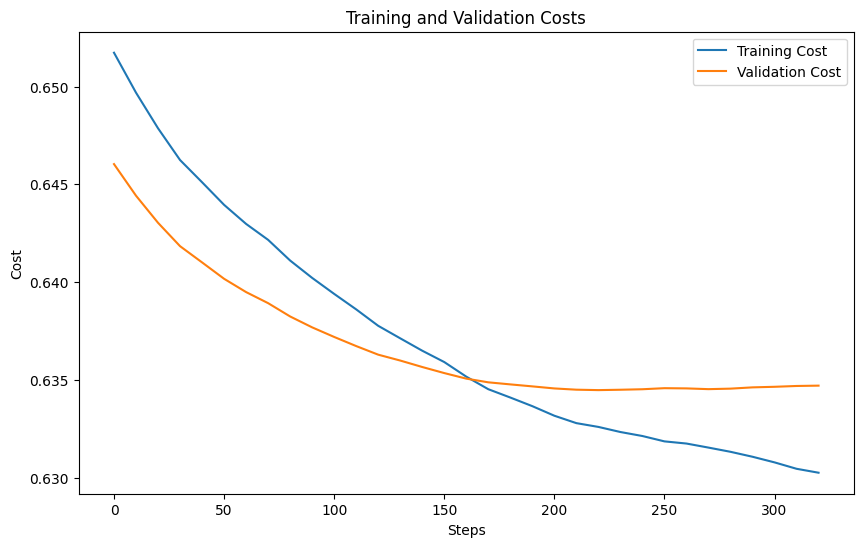

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_costs)*10, 10), train_costs, label='Training Cost')
plt.plot(range(0, len(val_costs)*10, 10), val_costs, label='Validation Cost')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title('Training and Validation Costs')
plt.legend()
plt.show()

### Model Evaluation: Test Accuracy and Sample Predictions

After training the Quantum Convolutional Neural Network (QCNN), we evaluate its performance on the validation dataset to assess its generalization capability and make predictions.

#### Test Accuracy

The test accuracy is computed by comparing the predicted labels to the true labels in the validation dataset. The model achieves a test accuracy of 0.6700, indicating that approximately 67% of the validation samples are correctly classified.

#### Imbalance Observation

To gain insights into the model's predictions, we examine a few sample outputs. For each sample, the true label, predicted label, and prediction probability are displayed. This helps in understanding the model's decision-making process. The model consistently predicts the label '1', regardless of the true label, likely due to an imbalance in the dataset. This suggests that the model is biased towards predicting the majority class, which can be a common issue when the dataset is not balanced.

#### Conclusion

The QCNN demonstrates moderate accuracy in classifying TIG welding defects. However, the consistent prediction of '1' highlights a potential issue with data imbalance, which may require addressing through techniques such as data augmentation, re-sampling, or using class weights during training to improve the model's performance.


In [15]:
test_predictions = pnp.array([quantum_net(x, best_weights) for x in x_val])
test_predictions = (test_predictions > 0.5).astype(int)
accuracy = pnp.mean(test_predictions == y_val)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nSample Predictions:")
for i in range(10):
    true_label = y_val[i]
    predicted_prob = quantum_net(x_val[i], best_weights)
    predicted_label = int(predicted_prob > 0.5)
    print(f"True: {true_label}, Predicted: {predicted_label} (Probability: {predicted_prob:.4f})")

Test Accuracy: 0.6700

Sample Predictions:
True: 1, Predicted: 1 (Probability: 0.5993)
True: 0, Predicted: 1 (Probability: 0.5993)
True: 1, Predicted: 1 (Probability: 0.5153)
True: 1, Predicted: 1 (Probability: 0.6964)
True: 1, Predicted: 1 (Probability: 0.6110)
True: 0, Predicted: 1 (Probability: 0.5153)
True: 0, Predicted: 1 (Probability: 0.6432)
True: 1, Predicted: 1 (Probability: 0.6964)
True: 1, Predicted: 1 (Probability: 0.6218)
True: 1, Predicted: 1 (Probability: 0.6323)


### Addressing Class Imbalance with Random Under-Sampling

In this section, we address the issue of class imbalance in the training and validation datasets by applying random under-sampling. This technique helps to balance the number of samples in each class, which can improve the model's performance by preventing it from being biased towards the majority class.

#### Random Under-Sampling

- The `RandomUnderSampler` class from the `imblearn` library is used to perform under-sampling.
- **Implementation**:
  - **Training Data**: The training dataset (`x_train`, `y_train`) is resampled to have an equal number of samples for each class.
  - **Validation Data**: Similarly, the validation dataset (`x_val`, `y_val`) is resampled to balance the classes.


In [35]:
size4 = (800, 947)
path = "./al5083"

train_dataset_2class = MyDataset(
    path=path,
    transform=transforms.Compose([
        transforms.Resize(size4),
        transforms.ToTensor(),
    ]),
    train=True,
    class2=True
)
test_dataset_2class = MyDataset(
    path=path,
    transform=transforms.Compose([
        transforms.Resize(size4),
        transforms.ToTensor(),
    ]),
    train=False,
    class2=True
)

subset_size = 1000
subset_indices = torch.randperm(len(train_dataset_2class))[:subset_size]
subset_train = Subset(train_dataset_2class, subset_indices)

test_subset_size = 500
test_subset_indices = torch.randperm(len(test_dataset_2class))[:test_subset_size]
subset_test = Subset(test_dataset_2class, test_subset_indices)

train_images, train_labels = tuple(zip(*subset_train))
test_images, test_labels = tuple(zip(*subset_test))

n_qubits = 4
n_layers = int(pnp.log2(n_qubits)) 

total_params = 4 * n_qubits - 4  
weights = pnp.random.uniform(0, 2*pnp.pi, total_params, requires_grad=True)

x_train, x_val = [x.detach().numpy()[0] for x in train_images], [x.detach().numpy()[0] for x in test_images]
y_train, y_val = np.array(train_labels), np.array(test_labels)
x_train, y_train, x_val, y_val = preprocess_dataset(x_train, x_val, y_train, y_val)

In [37]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)  
x_val, y_val = rus.fit_resample(x_val, y_val)  

### Class Distribution After Under-Sampling

After applying random under-sampling to address class imbalance in the dataset, we achieve an equal distribution of classes in the training set.

#### Class Distribution

- **Good Welds**: 50.0% of the samples in the training set are classified as good welds.
- **Bad Welds**: 50.0% of the samples in the training set are classified as bad welds.

This balanced distribution ensures that the Quantum Convolutional Neural Network (QCNN) does not favor one class over the other during training, which can lead to more accurate and fair predictions. By maintaining equal representation of both classes, the model is better equipped to learn distinguishing features of each class, ultimately improving its performance in classifying TIG welding defects.

In [38]:
goodweld_train_perc = len(y_train[y_train == 0]) / len(y_train) * 100
badweld_train_perc = len(y_train[y_train == 1]) / len(y_train) * 100
print("Percentage of good weld in the training set after undersampling:", goodweld_train_perc, "%")
print("Percentage of bad weld in the training set after undersampling:", badweld_train_perc, "%")

Percentage of good weld in the training set after undersampling: 50.0 %
Percentage of bad weld in the training set after undersampling: 50.0 %


In [24]:
opt = qml.AdamOptimizer(stepsize=0.001)
batch_size = 32
steps = 10000

best_val_cost = float('inf')
patience = 10 #20
no_improvement = 0

train_costs = []
val_costs = []

for i in range(steps):
    batch_indices = pnp.random.choice(len(x_train), batch_size, replace=False)
    x_batch = x_train[batch_indices]
    y_batch = y_train[batch_indices]
    
    weights = opt.step(lambda w: cost(w, x_batch, y_batch), weights)
    
    if (i + 1) % 10 == 0:
        train_cost = cost(weights, x_train, y_train)
        val_cost = cost(weights, x_val, y_val)
        train_costs.append(train_cost)
        val_costs.append(val_cost)
        print(f"Step {i+1}, Train Cost: {train_cost:.4f}, Validation Cost: {val_cost:.4f}")
        
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_weights = weights
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= patience:
            print(f"Early stopping at step {i+1}")
            break

Step 10, Train Cost: 0.9109, Validation Cost: 0.9058
Step 20, Train Cost: 0.8981, Validation Cost: 0.8922
Step 30, Train Cost: 0.8861, Validation Cost: 0.8794
Step 40, Train Cost: 0.8748, Validation Cost: 0.8674
Step 50, Train Cost: 0.8645, Validation Cost: 0.8564
Step 60, Train Cost: 0.8555, Validation Cost: 0.8469
Step 70, Train Cost: 0.8470, Validation Cost: 0.8380
Step 80, Train Cost: 0.8388, Validation Cost: 0.8294
Step 90, Train Cost: 0.8322, Validation Cost: 0.8226
Step 100, Train Cost: 0.8250, Validation Cost: 0.8152
Step 110, Train Cost: 0.8175, Validation Cost: 0.8074
Step 120, Train Cost: 0.8101, Validation Cost: 0.7999
Step 130, Train Cost: 0.8035, Validation Cost: 0.7933
Step 140, Train Cost: 0.7983, Validation Cost: 0.7880
Step 150, Train Cost: 0.7931, Validation Cost: 0.7827
Step 160, Train Cost: 0.7880, Validation Cost: 0.7776
Step 170, Train Cost: 0.7827, Validation Cost: 0.7726
Step 180, Train Cost: 0.7782, Validation Cost: 0.7683
Step 190, Train Cost: 0.7742, Validat

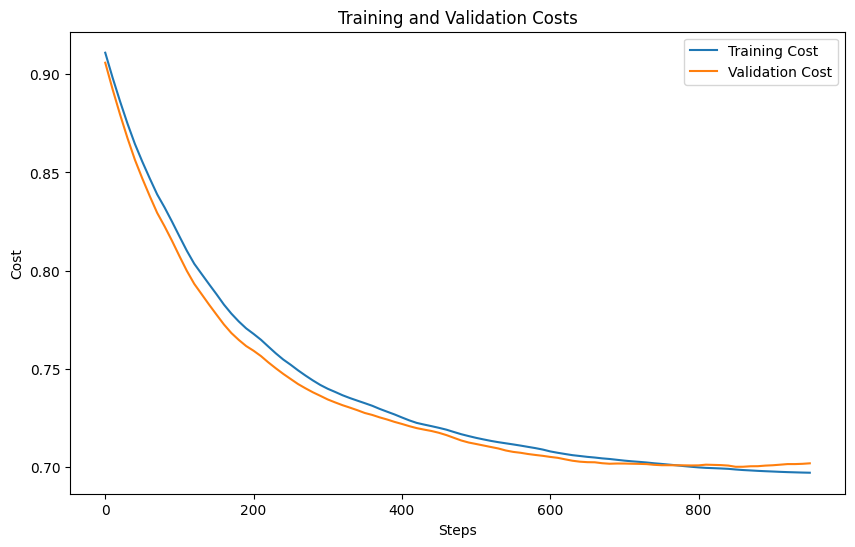

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_costs)*10, 10), train_costs, label='Training Cost')
plt.plot(range(0, len(val_costs)*10, 10), val_costs, label='Validation Cost')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title('Training and Validation Costs')
plt.legend()
plt.show()

In [31]:
from sklearn.utils import shuffle
x_val, y_val = shuffle(x_val, y_val)

In [33]:
test_predictions = pnp.array([quantum_net(x, best_weights) for x in x_val])
test_predictions = (test_predictions > 0.5).astype(int)
accuracy = pnp.mean(test_predictions == y_val)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nSample Predictions:")
for i in range(30):
    true_label = y_val[i]
    predicted_prob = quantum_net(x_val[i], best_weights)
    predicted_label = int(predicted_prob > 0.5)
    print(f"True: {true_label}, Predicted: {predicted_label} (Probability: {predicted_prob:.4f})")

Test Accuracy: 0.5429

Sample Predictions:
True: 0, Predicted: 0 (Probability: 0.4851)
True: 1, Predicted: 0 (Probability: 0.4386)
True: 0, Predicted: 0 (Probability: 0.4648)
True: 1, Predicted: 0 (Probability: 0.4529)
True: 1, Predicted: 0 (Probability: 0.4423)
True: 0, Predicted: 0 (Probability: 0.4809)
True: 1, Predicted: 0 (Probability: 0.4809)
True: 0, Predicted: 0 (Probability: 0.4648)
True: 0, Predicted: 0 (Probability: 0.4423)
True: 0, Predicted: 0 (Probability: 0.4408)
True: 0, Predicted: 0 (Probability: 0.4401)
True: 1, Predicted: 0 (Probability: 0.4462)
True: 1, Predicted: 0 (Probability: 0.4423)
True: 0, Predicted: 0 (Probability: 0.4423)
True: 1, Predicted: 0 (Probability: 0.4423)
True: 0, Predicted: 0 (Probability: 0.4648)
True: 0, Predicted: 0 (Probability: 0.4529)
True: 1, Predicted: 0 (Probability: 0.4809)
True: 1, Predicted: 1 (Probability: 0.5408)
True: 0, Predicted: 1 (Probability: 0.5182)
True: 1, Predicted: 0 (Probability: 0.4809)
True: 0, Predicted: 0 (Probabilit

### Analysis of Model Performance

The test accuracy of the Quantum Convolutional Neural Network (QCNN) is reported as 0.5429, indicating that the model correctly classifies approximately 54.29% of the validation samples. This result, although low, marks an improvement over previous iterations where the model could only predict one class.

#### Reasons for Low Accuracy

- **Model Complexity**: The QCNN architecture might not be sufficiently complex to capture the intricate patterns required for accurate classification of TIG welding defects. The limited number of qubits and layers could restrict the model's ability to learn complex decision boundaries.

- **Feature Representation**: The preprocessing steps, including dimensionality reduction to match the quantum circuit's input size, might have led to a loss of important features necessary for distinguishing between classes.

- **Training Dynamics**: Despite balancing the dataset, the model's training process might not have been optimal, potentially due to hyperparameter settings or the choice of optimizer.

#### Improved Class Prediction

- **Diverse Predictions**: Unlike previous results where the model predominantly predicted a single class, the current model is capable of predicting both classes. This indicates some level of learning and adaptation, suggesting that the model is beginning to differentiate between the two classes, albeit not with high accuracy.

- **Sample Predictions**: The sample predictions show that the model predicts both '0' and '1', with probabilities close to the decision threshold of 0.5. This suggests that the model is uncertain in its predictions, which could be improved with further tuning and training.

#### Conclusion

While the model's accuracy remains low, the ability to predict both classes is a positive development. Further improvements could be achieved by enhancing the model's complexity, refining the preprocessing pipeline, and experimenting with different training strategies. These steps could help in achieving better generalization and accuracy in classifying TIG welding defects.

## References

1. Bacioiu, D., Melton, G., Papaelias, M., & Shaw, R. (2019). Automated defect classification of Aluminium 5083 TIG welding using HDR camera and neural networks. *Journal of Manufacturing Processes, 45*, 603–613. [https://doi.org/10.1016/j.jmapro.2019.07.020](https://doi.org/10.1016/j.jmapro.2019.07.020)

2. Tak Hur, Leeseok Kim & Daniel K. Park (2022). Quantum convolutional neural network for classical data classification. *Quantum Machine Intelligence, 3*(1), 1-9. [https://link.springer.com/article/10.1007/s42484-021-00061-x](https://link.springer.com/article/10.1007/s42484-021-00061-x).

3. Heidari, M. (2021). Deep Learning for Image Classification. *Kaggle Notebook*. [https://www.kaggle.com/code/miladheidari/deeplearning](https://www.kaggle.com/code/miladheidari/deeplearning)

4. Tumre, S. (2021). How to Create a Subset of DataLoader in PyTorch and Why is it Important. *Medium*. [https://medium.com/@siddharth.tumre/how-to-create-a-subset-of-dataloader-in-pytorch-and-why-is-it-important-52c238a7199](https://medium.com/@siddharth.tumre/how-to-create-a-subset-of-dataloader-in-pytorch-and-why-is-it-important-52c238a7199)

5. Handling Imbalanced Datasets in scikit-learn: Techniques and Best Practices. *Data Science Horizons*. [https://datasciencehorizons.com/handling-imbalanced-datasets-in-scikit-learn-techniques-and-best-practices/](https://datasciencehorizons.com/handling-imbalanced-datasets-in-scikit-learn-techniques-and-best-practices/)